# HCP Dataset - Gambling Experiment

## Load HCP parcellated task data

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
N_SUBJECTS = 100
N_PARCELS = 360
TR = 0.72
HEMIS = ["Right", "Left"]
RUNS   = ['LR','RL']
N_RUNS = 2
EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

# Relevant ROI normalised timeseries plot with Trial Data (Loss, Win, Neutral)

In [13]:
# load the subject list
HCP_DIR = "./hcp_task"
subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

In [14]:
# set basic variables
subject = subjects[1]
experiment = "GAMBLING"
run = 1

In [15]:
# a function to load timeseries data
def load_single_timeseries(subject, experiment, run):
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  ts -= ts.mean(axis=1, keepdims=True) # normalising the data
  return ts

data = load_single_timeseries(subject, experiment, run)

In [16]:
# load ROI data and printing the unique values
regions = np.load(f"{HCP_DIR}/regions.npy").T
df = pd.DataFrame({'network' : regions[1],
                   'hemi' : ['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2)
                   })
print(df['network'].unique())

['Visual1' 'Visual2' 'Somatomotor' 'Cingulo-Oper' 'Language' 'Default'
 'Frontopariet' 'Auditory' 'Dorsal-atten' 'Posterior-Mu' 'Orbito-Affec'
 'Ventral-Mult']


In [17]:
#choosing a biologically relevant ROI
relevant_indices = df[df["network"] == "Orbito-Affec"].index.values
relevant_data_mean = data[relevant_indices, :].mean(axis=0)

In [18]:
# a function to load trial type data
def load_trials_type(subject, experiment, run):
  frames_dict = {}
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  EXPERIMENTS["GAMBLING"]['cond'].append("neut")
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}_event.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    start = np.floor(ev["onset"] / TR).astype(int)
    duration = np.ceil(ev["duration"] / TR).astype(int)
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_dict[cond] = frames

  return frames_dict


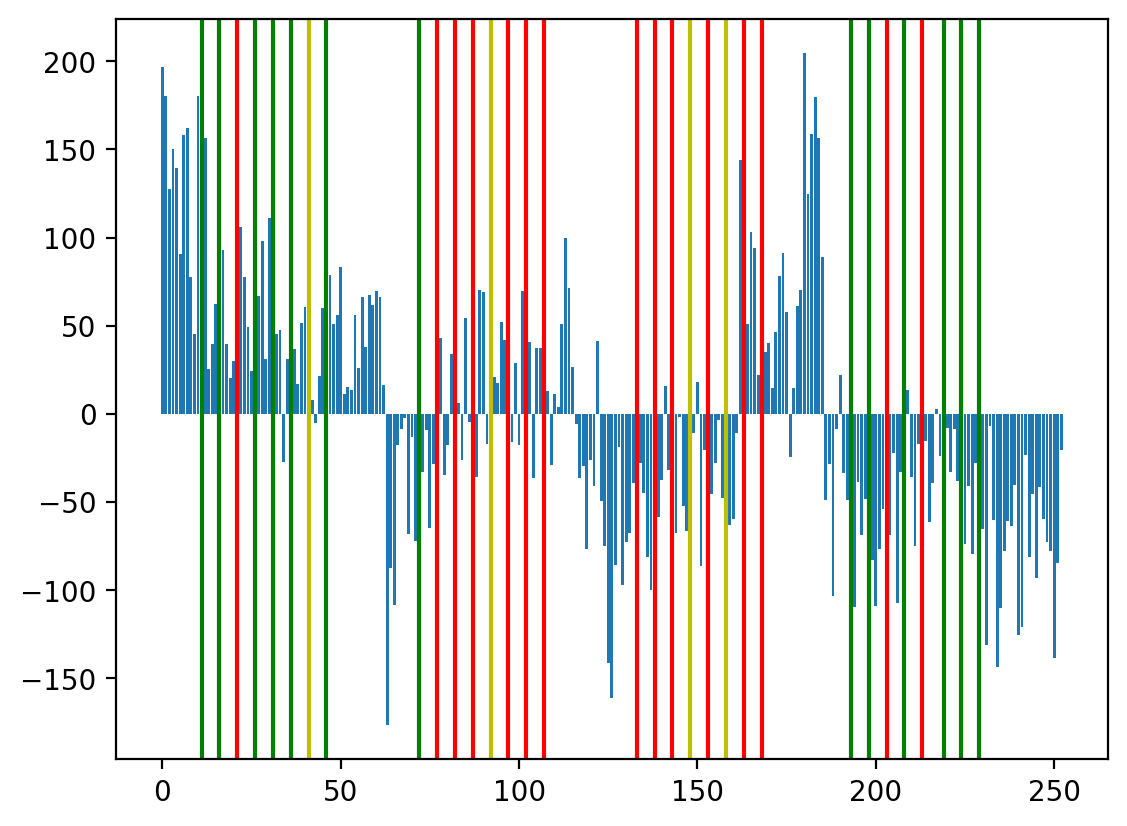

In [19]:
# plotting the trial data on relevant data mean
plt.bar(np.arange(data.shape[1]), relevant_data_mean)
trials = load_trials_type(subject, experiment, run)
for cond in trials:
    for arr in trials[cond]:
        if cond=="loss":
            plt.axvline(arr[0],color='r')
        elif cond=="win":
            plt.axvline(arr[0],color='g')
        else:
            plt.axvline(arr[0],color='y')

# USELESS CODE DUMPYARD
#### (I mean, these are useless at the moment, might be quite useful in the near future)

### Data Importer (in case you don't have them locally)

In [ ]:
# from collections import Counter

# def get_subject_data(subject_id, column_number):
#     file_name = "demo_data.csv"
#     url = "https://raw.githubusercontent.com/drarkadeep/assets/main/demo_data.csv"

#     try:
#         if not os.path.exists(file_name):
#             response = requests.get(url)
#             response.raise_for_status()
#             with open(file_name, 'wb') as f:
#                 f.write(response.content)

#         df = pd.read_csv(file_name)

#         if column_number >= len(df.columns):
#             raise ValueError(f"Column number {column_number} is out of range.")

#         row = df[df.iloc[:, 0] == int(subject_id)]

#         if row.empty:
#             print(f"No data found for subject ID: {subject_id}")
#             return None

#         return row.iloc[0, column_number]

#     except requests.RequestException as e:
#         print(f"Error downloading the CSV: {str(e)}")
#         return None
#     except pd.errors.EmptyDataError:
#         print("Error: The CSV file is empty.")
#         return None
#     except Exception as e:
#         print(f"An error occurred: {str(e)}")
#         return None

# def get_subject_gender(subject_id):
#     gender = get_subject_data(subject_id, column_number=3)
#     return gender

# def get_subject_age(subject_id):
#     gender = get_subject_data(subject_id, column_number=4)
#     return gender

# def basic_demographic_analysis(data):
#   element_counts = Counter(data)
#   return element_counts

# print(get_subject_gender(subjects[1]))
# print(get_subject_age(subjects[1]))

# gender_data = []
# age_data = []
# for i in range(len(subjects)):
#     gender_data.append(get_subject_gender(subjects[i]))
# for i in range(len(subjects)):
#     age_data.append(get_subject_age(subjects[i]))

# gender_counts = basic_demographic_analysis(gender_data, 0)
# print(gender_counts)
# age_counts = basic_demographic_analysis(age_data, 1)
# print(age_counts)

In [5]:
# # @title Download data file
# import os, requests

# fname = "hcp_task.tgz"
# url = "https://osf.io/2y3fw/download"

# if not os.path.isfile(fname):
#   try:
#     r = requests.get(url)
#   except requests.ConnectionError:
#     print("!!! Failed to download data !!!")
#   else:
#     if r.status_code != requests.codes.ok:
#       print("!!! Failed to download data !!!")
#     else:
#       with open(fname, "wb") as fid:
#         fid.write(r.content)
# The download cells will store the data in nested directories starting here:
# HCP_DIR = "./hcp_task"

# # importing the "tarfile" module
# import tarfile

# if not os.path.exists(HCP_DIR):
#     # If the folder does not exist, create it and extract the tar file
#     os.makedirs(HCP_DIR)
#     # open file
#     with tarfile.open(fname) as tfile:
#       # extracting file
#       tfile.extractall('.')

### Helper functions

In [8]:
# def load_single_timeseries(subject, experiment, run, remove_mean=True):
#   """Load timeseries data for a single subject and single run.

#   Args:
#     subject (str):      subject ID to load
#     experiment (str):   Name of experiment
#     run (int):          (0 or 1)
#     remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

#   Returns
#     ts (n_parcel x n_timepoint array): Array of BOLD data values

#   """
#   bold_run  = RUNS[run]
#   bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
#   bold_file = "data.npy"
#   ts = np.load(f"{bold_path}/{bold_file}")
#   if remove_mean:
#     ts -= ts.mean(axis=1, keepdims=True)
#   return ts


# def load_evs(subject, experiment, run):
#   """Load EVs (explanatory variables) data for one task experiment.

#   Args:
#     subject (str): subject ID to load
#     experiment (str) : Name of experiment
#     run (int): 0 or 1

#   Returns
#     evs (list of lists): A list of frames associated with each condition

#   """
#   frames_list = []
#   task_key = f'tfMRI_{experiment}_{RUNS[run]}'
#   for cond in EXPERIMENTS[experiment]['cond']:
#     ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
#     ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
#     ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
#     # Determine when trial starts, rounded down
#     start = np.floor(ev["onset"] / TR).astype(int)
#     # Use trial duration to determine how many frames to include for trial
#     duration = np.ceil(ev["duration"] / TR).astype(int)
#     # Take the range of frames that correspond to this specific trial
#     frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
#     frames_list.append(frames)

#   return frames_list

# def load_evs_type(subject, experiment, run):
#   """Load EVs (explanatory variables) data for one task experiment.

#   Args:
#     subject (str): subject ID to load
#     experiment (str) : Name of experiment
#     run (int): 0 or 1

#   Returns:
#     evs (dict): A dictionary of frames associated with each condition, keyed by condition name

#   """
#   frames_dict = {}
#   task_key = f'tfMRI_{experiment}_{RUNS[run]}'
#   for cond in EXPERIMENTS[experiment]['cond']:
#     ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
#     ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
#     ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
#     # Determine when trial starts, rounded down
#     start = np.floor(ev["onset"] / TR).astype(int)
#     # Use trial duration to determine how many frames to include for trial
#     duration = np.ceil(ev["duration"] / TR).astype(int)
#     print(start)
#     #print(duration)
#     # Take the range of frames that correspond to this specific trial
#     frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
#     frames_dict[cond] = frames

#   return frames_dict


### OG NMA notebook stuff

In [87]:

# import seaborn as sns
# # we need a little function that averages all frames from any given condition
# def average_frames(data, evs, experiment, cond):
#   idx = EXPERIMENTS[experiment]['cond'].index(cond)
#   return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


# lf_activity = average_frames(data, evs, my_exp, 'loss')
# rf_activity = average_frames(data, evs, my_exp, 'win')
# contrast = lf_activity - rf_activity  # difference between left and right hand movement
# # Plot activity level in each ROI for both conditions
# plt.plot(lf_activity,label='left foot')
# plt.plot(rf_activity,label='right foot')
# plt.xlabel('ROI')
# plt.ylabel('activity')
# plt.legend()
# plt.show()
# df = pd.DataFrame({'lf_activity' : lf_activity,
#                    'rf_activity' : rf_activity,
#                    'network' : region_info['network'],
#                    'hemi' : region_info['hemi']})

# fig, (ax1, ax2) = plt.subplots(1, 2)
# sns.barplot(y='network', x='lf_activity', data=df, hue='hemi',ax=ax1)
# sns.barplot(y='network', x='rf_activity', data=df, hue='hemi',ax=ax2)
# plt.show()

# group_contrast = 0
# for s in subjects:
#   for r in [0, 1]:
#     data = load_single_timeseries(subject=s, experiment=my_exp,
#                                   run=r, remove_mean=True)
#     evs = load_evs(subject=s, experiment=my_exp,run=r)

#     lf_activity = average_frames(data, evs, my_exp, 'loss')
#     rf_activity = average_frames(data, evs, my_exp, 'win')

#     contrast = lf_activity - rf_activity
#     group_contrast += contrast

# group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

# df = pd.DataFrame({'contrast' : group_contrast,
#                    'network' : region_info['network'],
#                    'hemi' : region_info['hemi']
#                    })
# # we will plot the left foot minus right foot contrast so we only need one plot
# plt.figure()
# sns.barplot(y='network', x='contrast', data=df, hue='hemi')
# plt.show()

### Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [10]:
# # @title NMA provides an atlas. Run this cell to download it
# import os, requests

# # NMA provides an atlas
# fname = f"{HCP_DIR}/atlas.npz"
# url = "https://osf.io/j5kuc/download"

# if not os.path.isfile(fname):
#   try:
#     r = requests.get(url)
#   except requests.ConnectionError:
#     print("!!! Failed to download data !!!")
#   else:
#     if r.status_code != requests.codes.ok:
#       print("!!! Failed to download data !!!")
#     else:
#       with open(fname, "wb") as fid:
#         fid.write(r.content)

# with np.load(fname) as dobj:
#   atlas = dict(**dobj)

# # This uses the nilearn package
# from nilearn import plotting, datasets

# # Try both hemispheres (L->R and left->right)
# fsaverage = datasets.fetch_surf_fsaverage()
# surf_contrast = group_contrast[atlas["labels_L"]]
# plotting.view_surf(fsaverage['infl_left'],
#                    surf_contrast,
#                    vmax=20)